In [36]:
import os
import matplotlib.pyplot as plt
import cv2
import logging
import numpy as np
import torch
import torchvision.ops as ops


In [37]:
folder_path = './Dataset/arena/sbd'

raw_sbd = []
# Duyệt qua tất cả các tệp trong thư mục
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    raw_sbd.append(file_path)
print(len(raw_sbd))

3021


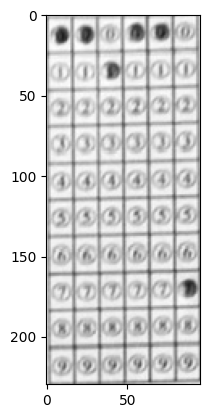

In [40]:

image = cv2.imread(raw_sbd[10])
plt.imshow(image)


/home/tuan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


50


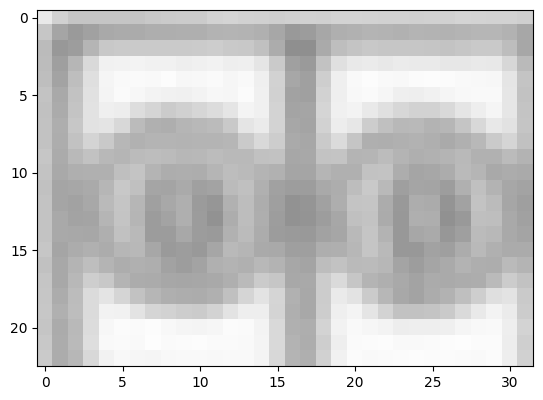

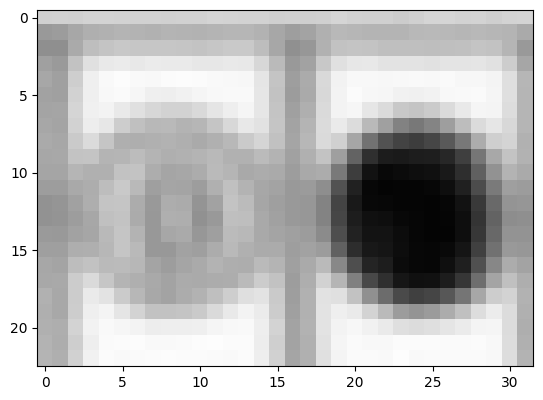

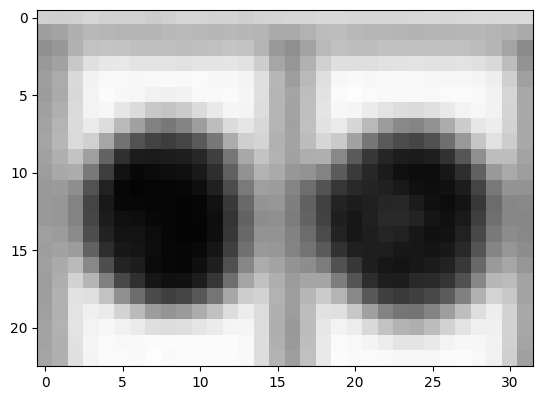

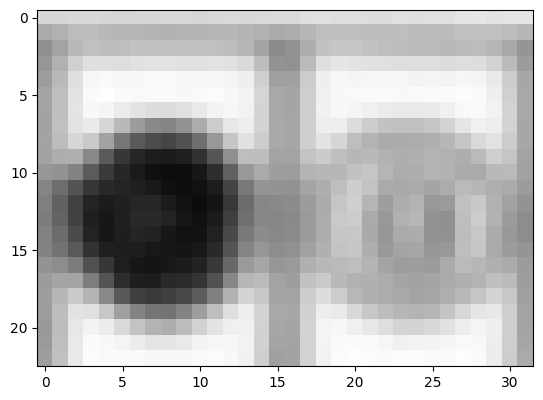

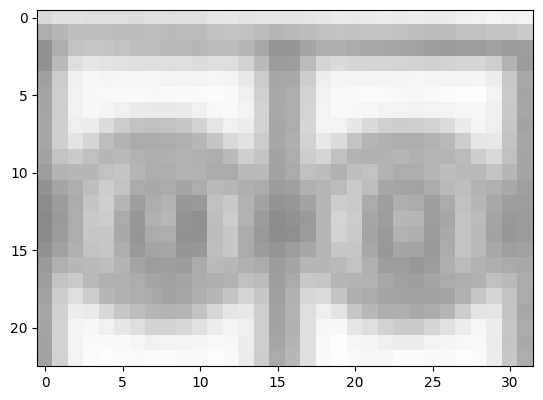

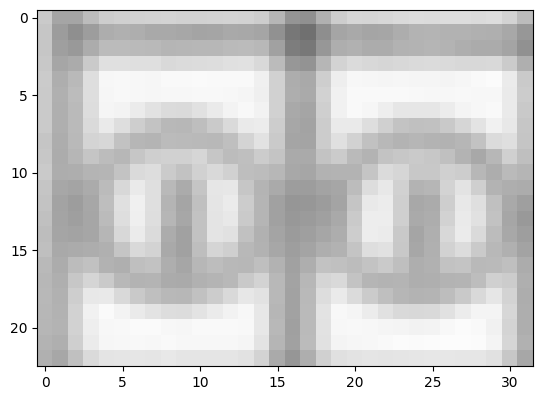

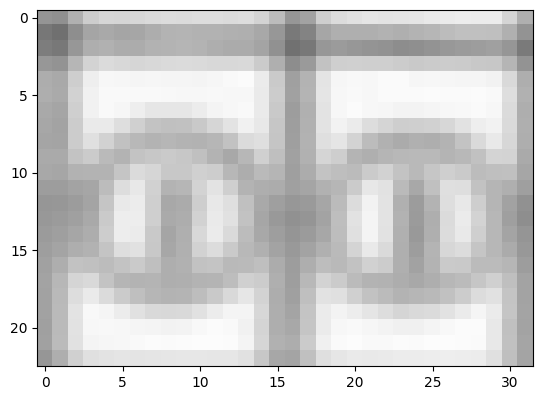

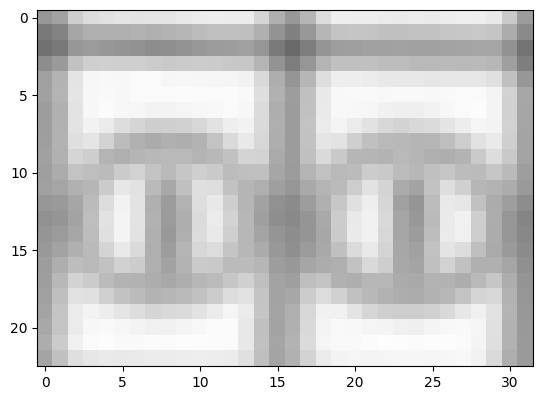

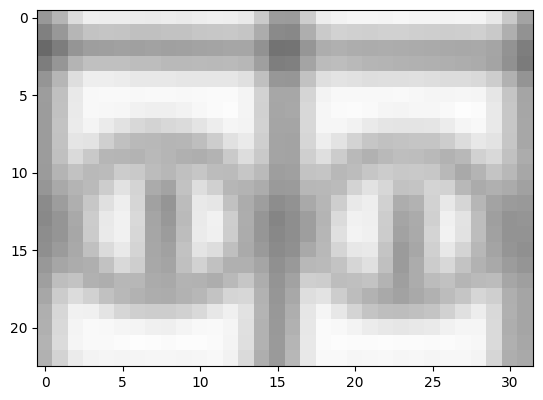

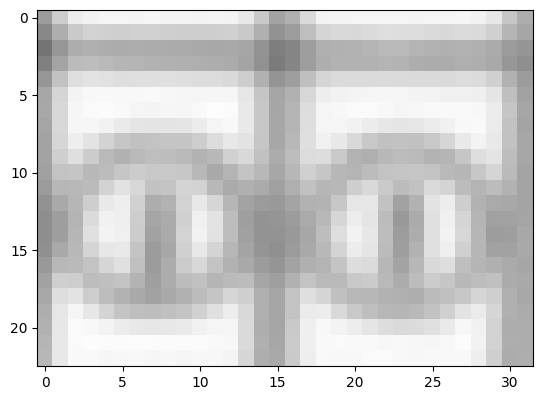

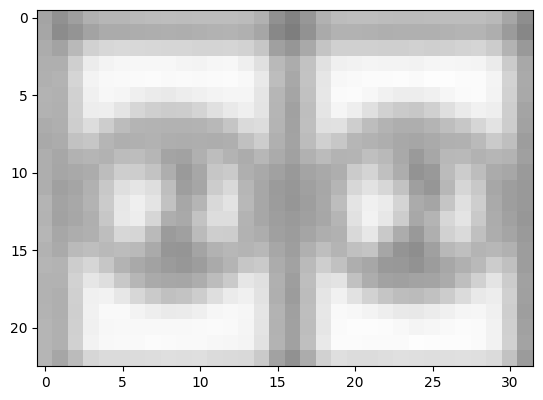

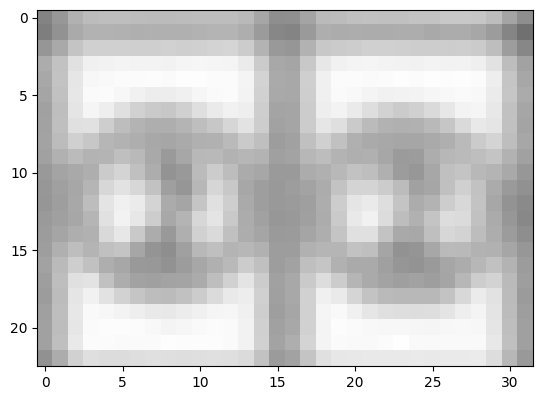

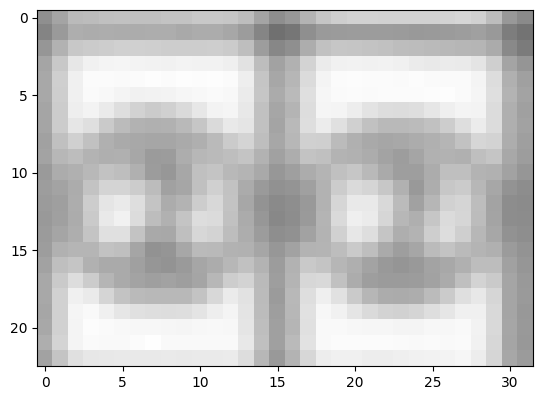

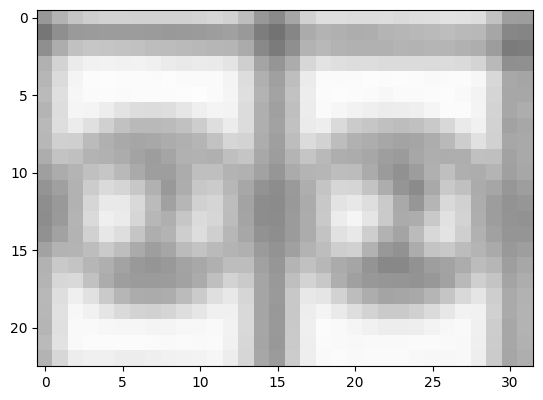

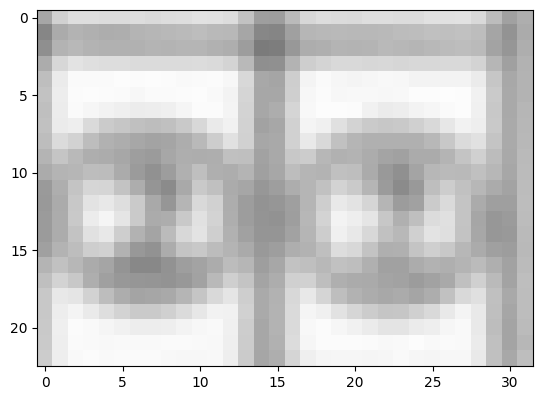

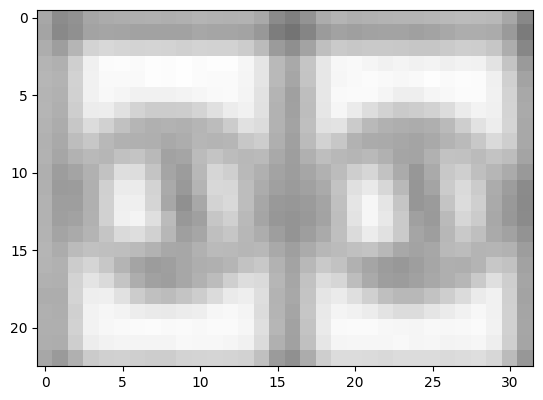

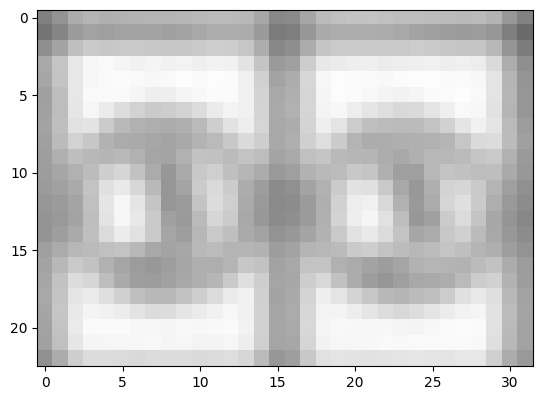

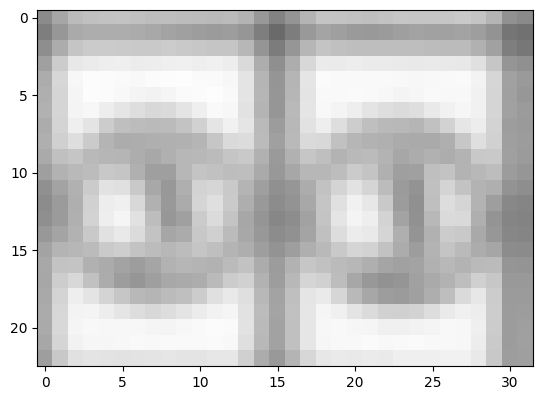

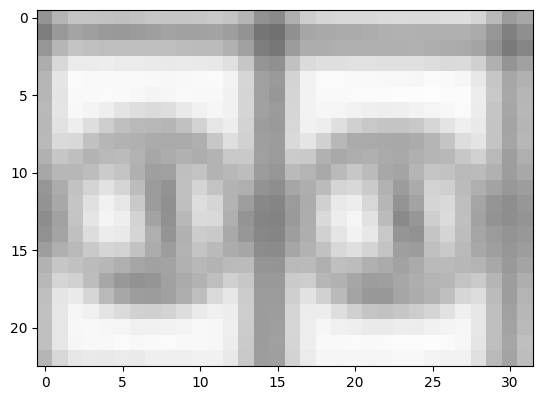

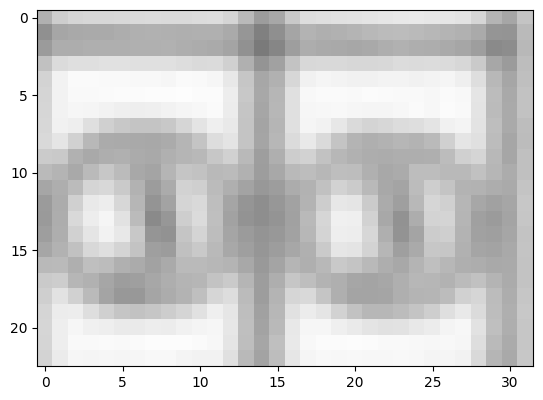

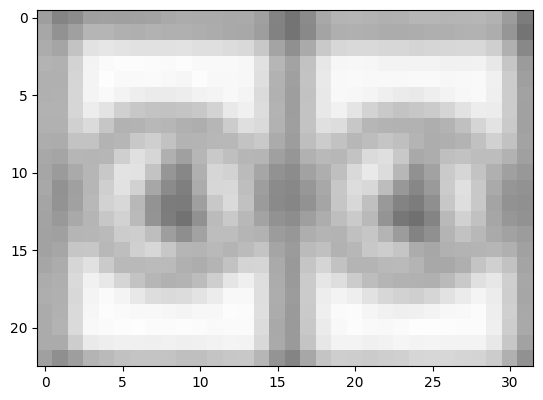

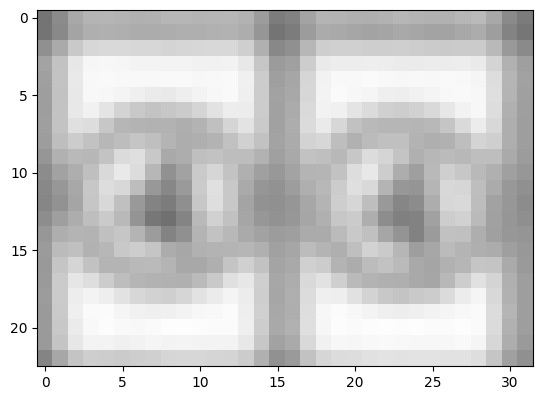

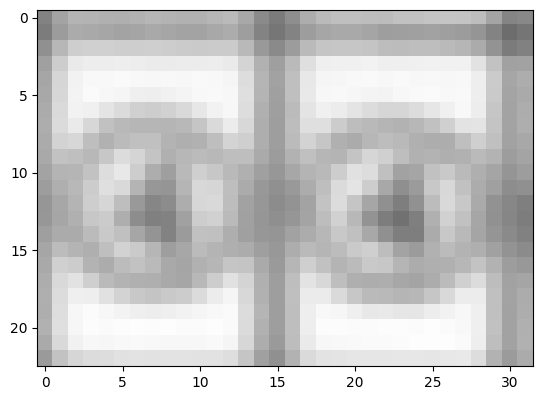

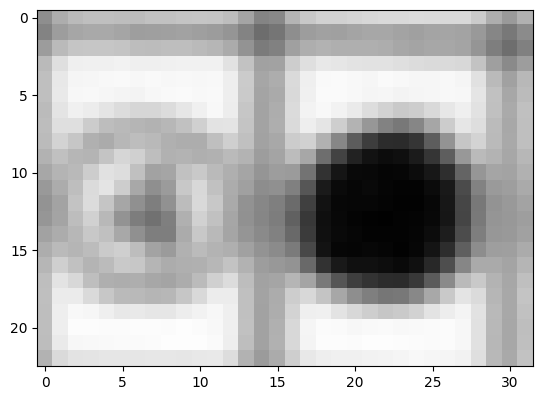

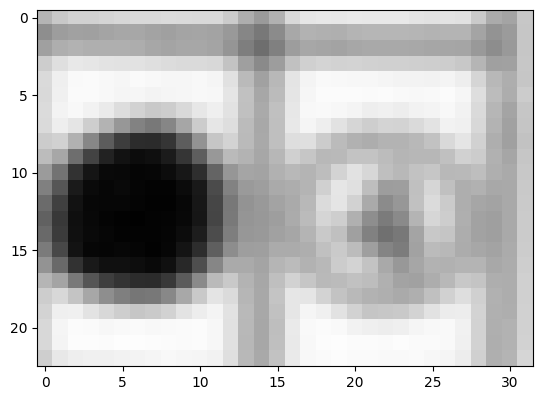

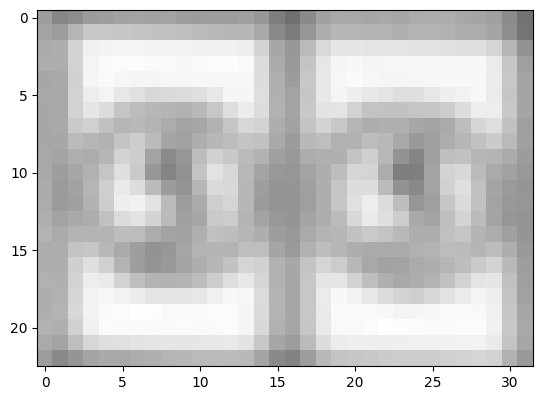

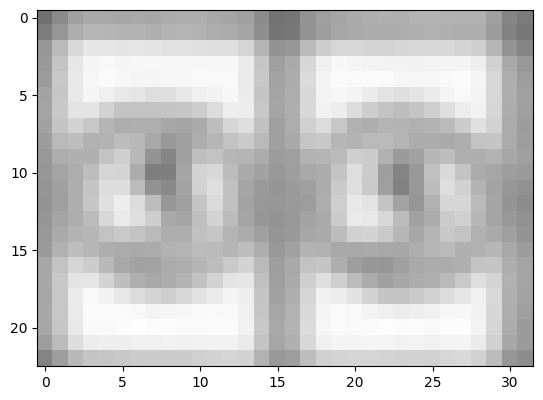

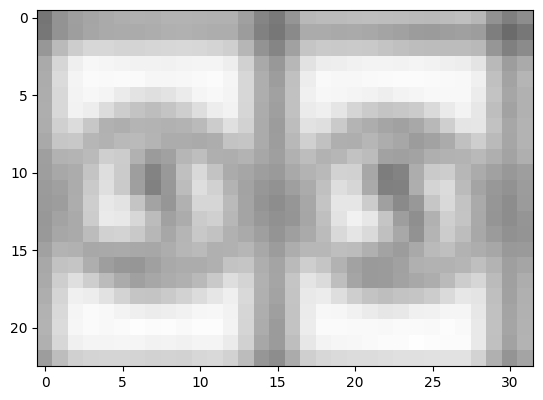

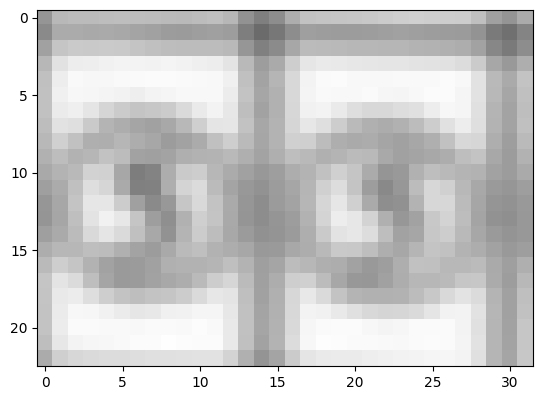

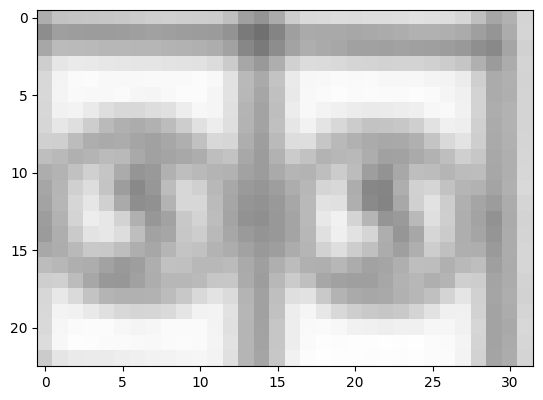

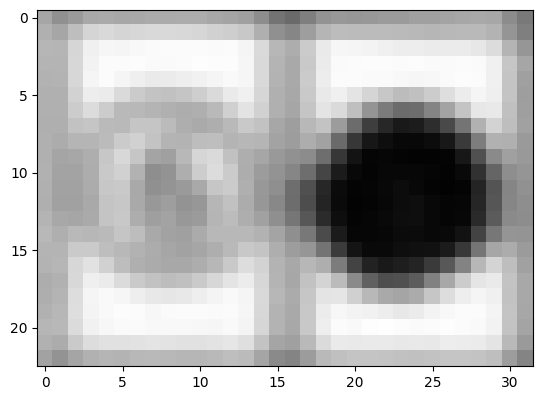

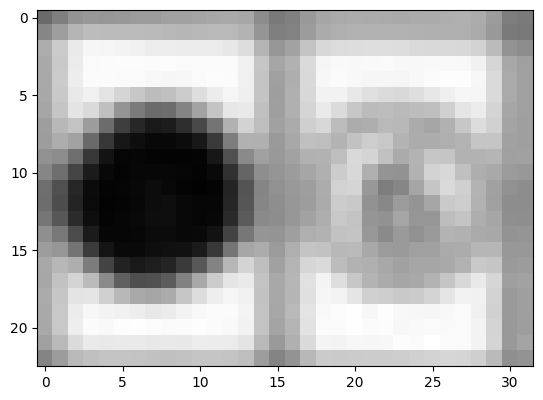

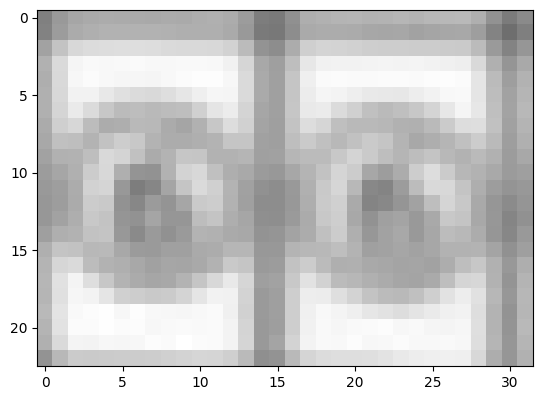

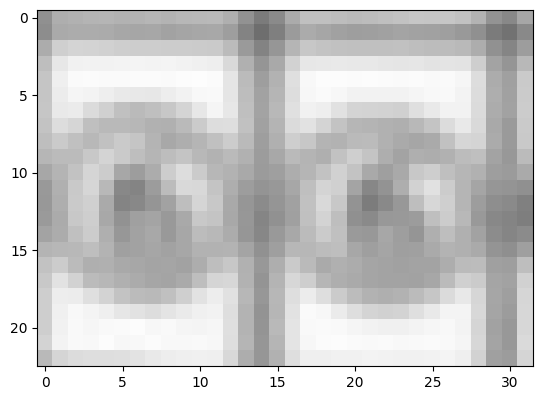

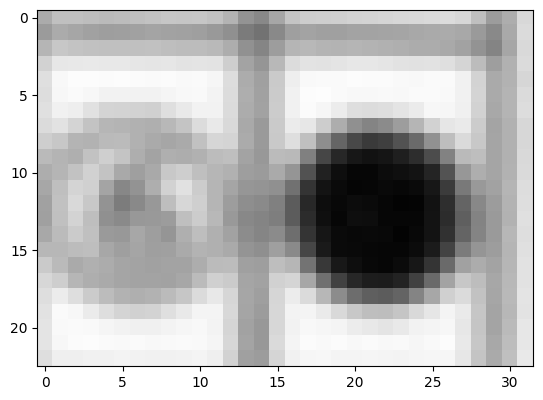

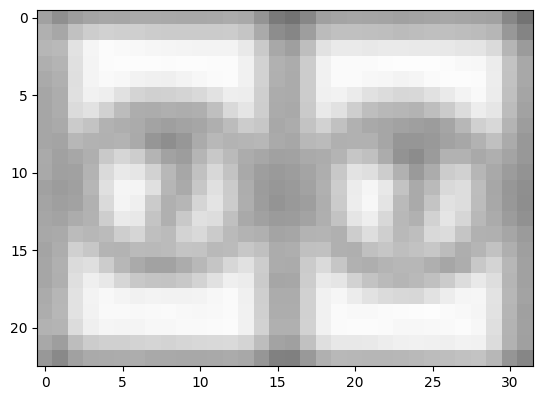

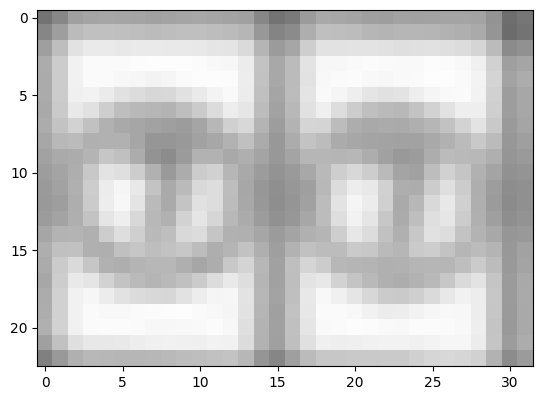

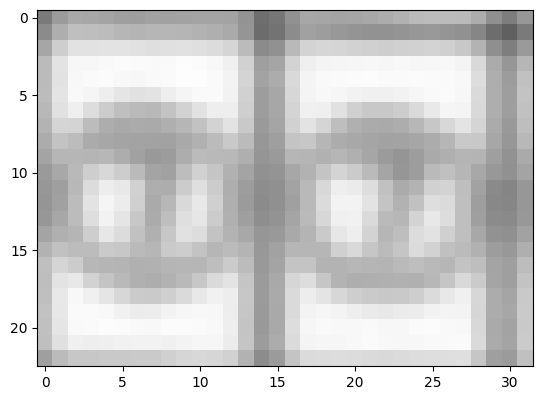

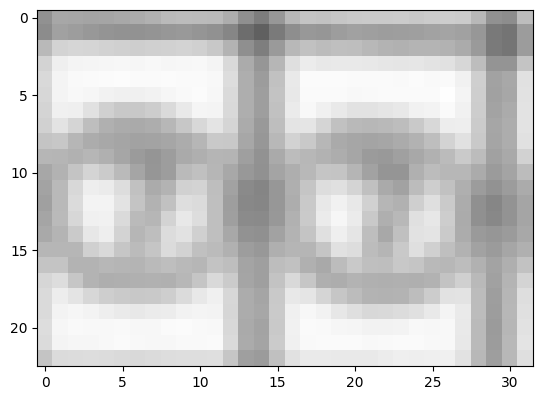

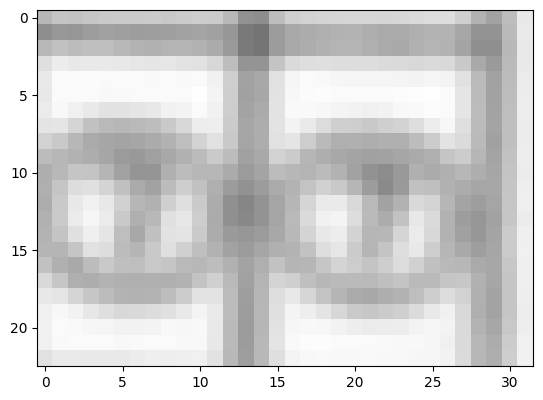

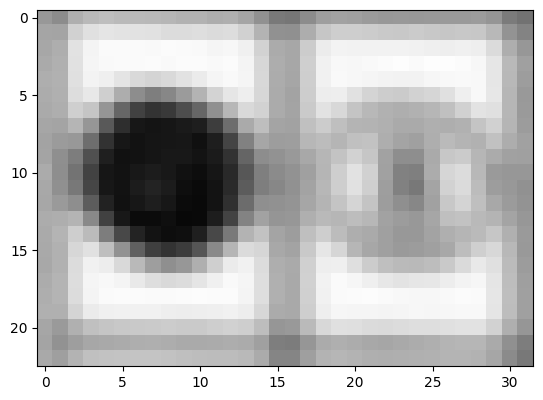

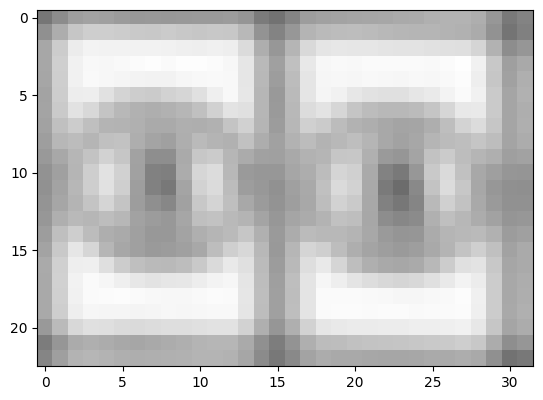

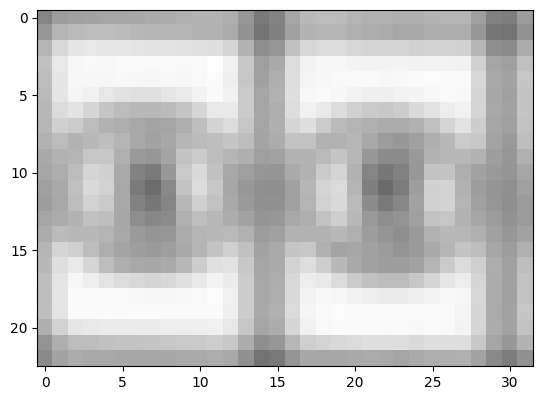

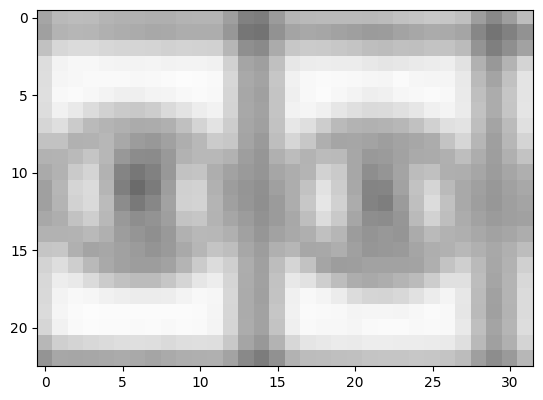

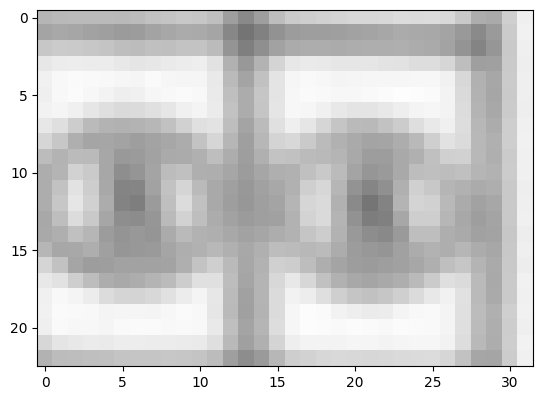

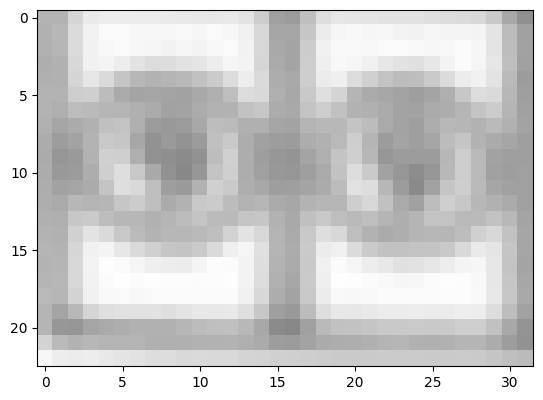

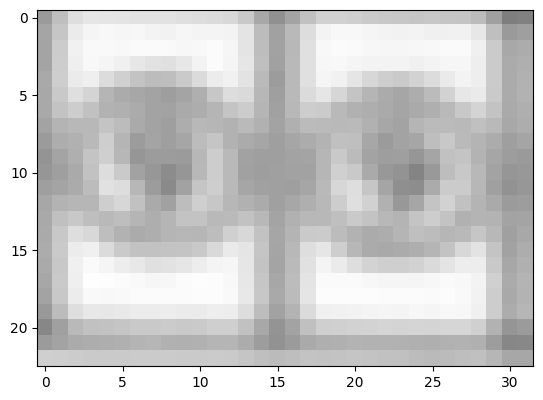

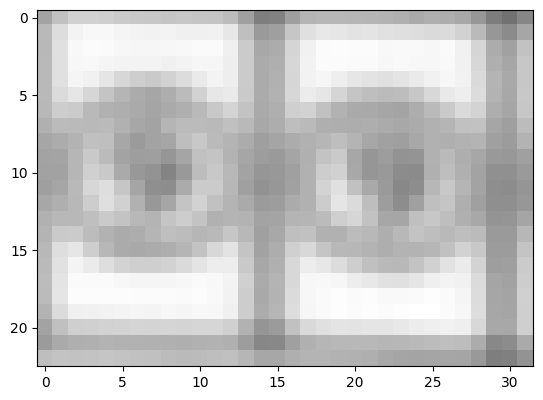

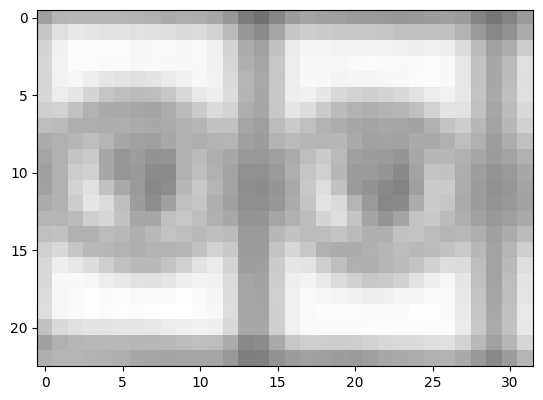

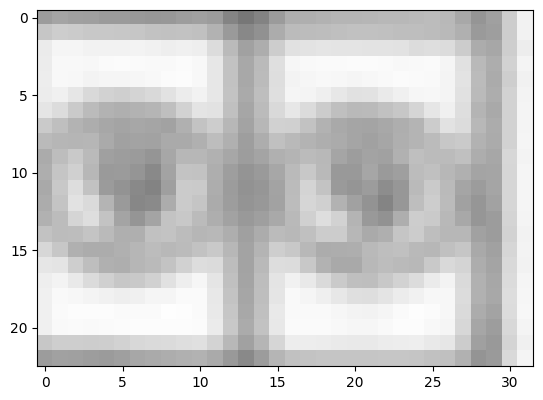

In [1]:
import cv2
import matplotlib.pyplot as plt

def crop_image(image, row_step=23, col_step=16, row_start=0, row_end=208, col_start=0, col_end=65, crop_height=23, crop_width=32):
    """
    Cắt ảnh thành các mảnh con theo cấu trúc bước nhảy, tức là cắt liên tục 2 ô, 12,23,34,...

    Parameters:
        - image: Ảnh đầu vào (numpy array).
        - row_step: Bước nhảy theo chiều dọc.
        - col_step: Bước nhảy theo chiều ngang.
        - row_start, row_end: Vị trí bắt đầu và kết thúc cắt theo chiều dọc.
        - col_start, col_end: Vị trí bắt đầu và kết thúc cắt theo chiều ngang.
        - crop_height, crop_width: Kích thước của mỗi mảnh ảnh cắt ra.

    Returns:
        - None: Hàm chỉ hiển thị các mảnh ảnh.
    """
    crop_img_sbd_mdt = []
    for i in range(row_start, row_end, row_step):
        for j in range(col_start, col_end, col_step):
            imgcrop = image[i:i+crop_height, j:j+crop_width]
            crop_img_sbd_mdt.append(imgcrop)
    return crop_img_sbd_mdt

# Đọc ảnh
image = cv2.imread('/mnt/d/examgrading/BuilModelDetecSBD_DT/Dataset/arena/sbd/SBD.victory_school.0475.jpg')
list_crop = crop_image(image)

print(len(list_crop))
for image in list_crop:
    plt.imshow(image)
    plt.show()


In [46]:
def template_matching(img, template_path, threshold=0.3):
    """
    Thực hiện so khớp mẫu để phát hiện mẫu trong ảnh đã cho.
    
    Tham số:
        - img: Ảnh cần so khớp mẫu.
        - template_path: Đường dẫn tới ảnh mẫu.
        - threshold: Ngưỡng tương tự để quyết định mẫu có khớp hay không.
        
    Trả về:
        - boxes: Danh sách các bounding box nơi mẫu được tìm thấy.
        - res: Kết quả của quá trình so khớp mẫu (ma trận tương tự).
    """
    # Đọc mẫu và thay đổi kích thước
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    template = cv2.resize(template, (13, 13))
    w, h = template.shape[::-1]
    
    # So khớp mẫu với ảnh
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    yloc, xloc = np.where(res >= threshold)  # Tìm các vị trí có giá trị tương tự lớn hơn hoặc bằng ngưỡng
    
    # Xây dựng danh sách bounding boxes từ các vị trí tìm được
    boxes = []
    for (x, y) in zip(xloc, yloc):
        boxes.append([x, y, x + w, y + h])  # [x1, y1, x2, y2]
    
    return boxes, res

def apply_nms(boxes, scores, iou_threshold=0.5):
    """
    Áp dụng non-maximum suppression (NMS) để loại bỏ các box dư thừa dựa trên ngưỡng IoU.
    
    Tham số:
        - boxes: Danh sách các bounding box.
        - scores: Danh sách các điểm số tương ứng với các bounding box.
        - iou_threshold: Ngưỡng IoU để quyết định xem hai box có chồng lấn nhau quá nhiều hay không.
        
    Trả về:
        - keep: Danh sách chỉ số của các box được giữ lại sau khi áp dụng NMS.
    """
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Áp dụng NMS để giữ lại các box có điểm số cao và không chồng lấn quá nhiều
    keep = ops.nms(boxes_tensor, scores_tensor, iou_threshold=iou_threshold)
    return keep

def generate_label(td):
    """
    Sinh nhãn dựa trên số lượng và vị trí của các đặc trưng đã phát hiện.
    
    Tham số:
        - td: Danh sách các trung tâm đặc trưng đã phát hiện.
        
    Trả về:
        - label: Nhãn dưới dạng chuỗi.
    """
    if len(td) < 2:
        if len(td) == 1:
            label = "10" if td[0] < 16 else "01"
        else:
            label = "00"
    else:
        label = "11"
    
    return label

def process_cropped_images(list_crop, template_path, image_save_path, label_save_path, threshold=0.6, nms_threshold=0.5):
    """
    Xử lý các ảnh đã cắt và áp dụng các bước: lưu ảnh, so khớp mẫu, NMS, và tạo nhãn.
    
    Tham số:
        - list_crop: Danh sách các ảnh đã cắt cần xử lý.
        - template_path: Đường dẫn tới mẫu để so khớp.
        - image_save_path: Đường dẫn nơi lưu ảnh sau khi xử lý.
        - label_save_path: Đường dẫn nơi lưu nhãn tương ứng.
        - threshold: Ngưỡng tương tự cho quá trình so khớp mẫu.
        - nms_threshold: Ngưỡng IoU cho NMS.
    """
    tg = 0  # Khởi tạo tg để theo dõi số lượng ảnh
    
    for img in list_crop:
        # Tạo tên cho ảnh dựa trên giá trị của tg
        img_name = f"crop_{tg}.jpg"
        dd = os.path.join(image_save_path, img_name)  # Đường dẫn để lưu ảnh
        dl = os.path.join(label_save_path, f"{tg}{img_name}.txt")  # Đường dẫn để lưu nhãn

        # Lưu ảnh đã cắt
        cv2.imwrite(dd, img)

        # Thực hiện so khớp mẫu
        boxes, res = template_matching(img, template_path, threshold)

        td = []  # Danh sách lưu các vị trí đặc trưng đã phát hiện
        if len(boxes) > 0:
            # Lấy điểm số tương ứng với tất cả các bounding box
            scores = res[boxes[0][1], boxes[0][0]]  # Lấy điểm số cho box đầu tiên
            scores = [res[y, x] for (x, y) in zip([box[0] for box in boxes], [box[1] for box in boxes])]  # Lấy điểm số cho tất cả các box

            keep = apply_nms(boxes, scores, iou_threshold=nms_threshold)  # Áp dụng NMS

            for j in keep:
                box = boxes[j]
                crop = img[box[1]:box[3], box[0]:box[2]]  # Cắt vùng chứa mẫu
                if np.mean(crop) < 100:  # Giả sử giá trị trung bình thấp là dấu hiệu của sự khớp mẫu
                    td.append((box[0] + box[2]) / 2)

        # Tạo nhãn dựa trên các đặc trưng đã phát hiện
        label = generate_label(td)

        # Ghi nhãn vào file
        with open(dl, "w") as file:
            file.write(label)

        tg += 1  # Tăng tg sau mỗi lần xử lý ảnh


In [ ]:
process_cropped_images(list_crop, 
                       './Dataset/template/templateChoice.jpg', 
                       './Dataset/data/image', 
                       './Datasetdata/label')